<h1 align="center"><font color='royalblue'> ADA - Project ADACONDA</font></h1> 

**Students:**
- ABI FADEL Zad
- ADEYE Abiola
- BRUNO Etienne
- FERCHIOU Sami

In [1]:
# Imports all required libraries
import sqlite3
import plotly.express as px
import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from dask.distributed import Client
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from utils.constants import BigMarketsSubset, SmallMarketsSubset, Correspondence, BigMarkets, SmallMarkets, MediumMarkets
from data.API_KEYS import chart_studio_key, chart_studio_username
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from math import log
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px
import logging
import os

# Sets up logging to Plotly
username = chart_studio_username
api_key = chart_studio_key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

# Default settings for matplotlib
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
# Dask Client with number of workers equal to number of cores
n_workers = os.cpu_count()
client = Client(n_workers=10, silence_logs=logging.ERROR)
client

2022-12-23 15:38:28,613 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/dj/cqrjzx2j27x69jdjypm1q9y00000gn/T/dask-worker-space/worker-6br_u2si', purging
2022-12-23 15:38:28,614 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/dj/cqrjzx2j27x69jdjypm1q9y00000gn/T/dask-worker-space/worker-xvfa9q0x', purging
2022-12-23 15:38:28,614 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/dj/cqrjzx2j27x69jdjypm1q9y00000gn/T/dask-worker-space/worker-qlqgs6f4', purging
2022-12-23 15:38:28,614 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/dj/cqrjzx2j27x69jdjypm1q9y00000gn/T/dask-worker-space/worker-5ezzq6n6', purging
2022-12-23 15:38:28,615 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/dj/cqrjzx2j27x69jdjypm1q9y00000gn/T/dask-worker-space/worker-v7f8nd62', purging
2022-12-23 15:38:28,615 - distributed.diskutils - INFO - Found st

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51364,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:51414,Total threads: 1
Dashboard: http://127.0.0.1:51418/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:51368,


## DATA PREPARATION

<div class="alert alert-block alert-info">
Our first step is to prepare the dataframe on which we will conduct our analysis. We then load our data in parquet format and filter the categories of videos that are the most insightful for us. This step permits us to focus on the videos that are the most interesting for our research, remove noise from irrelevant categories and make our queries faster. <br>
Therefore, we filter our videos to only keep categories Sports, People & Blogs and Entertainment.

In [3]:
video_metadata_df = dd.read_parquet("./data/video_metadata/parquet/")
video_metadata_df["upload_date"] = dd.to_datetime(video_metadata_df.upload_date)

In [4]:
video_metadata_df_sports = video_metadata_df[video_metadata_df["categories"].isin(["Sports", "People & Blogs", "Entertainment"])]
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].str.lower()
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].apply(lambda x: f",{x},", meta=("tags", "object"))

In [5]:
date_obj = video_metadata_df_sports.upload_date.dt
group_by = [date_obj.year, date_obj.month, video_metadata_df.categories]
video_metadata_df_sports_grouped = video_metadata_df_sports[["upload_date"]].groupby(by=group_by).count().persist()

In [6]:
required_tags = ["nba", "basketball"]

# Verifying that each video contains the required tags
nba_basketball_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains(f',{",|,".join(required_tags)},')].persist()
nba_basketball_df["year_month"] = dd.to_datetime(nba_basketball_df.upload_date.dt.year.astype("str") + "-" + nba_basketball_df.upload_date.dt.month.astype("str"))
nba_basketball_df.head(2)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,year_month
12154,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:21.268794,Lacey Leaves Us! Crazy Basketball!\n\nWhat a ...,12.0,Roa9Qlaao3k,590,1232.0,",lacey leaves us,crazy basketball,lacey,crazy,...",LACEY LEAVES US! | CRAZY BASKETBALL!,2018-01-20,42250,2018-01-01
12171,People & Blogs,UCzVxzz60KHq5Bgqf1zqoocg,2019-11-17 22:51:31.053243,Dance! Cheer at Basketball! Vlogmas Day 16!\...,7.0,ta-GIdaF7k8,477,770.0,",halftime performace,cheer at basketball,vlogm...",HALFTIME PERFORMANCE! | CHEER AT BASKETBALL! |...,2017-12-16,17340,2017-12-01


In [7]:
# Print dictionary of the big market teams
print('BigMarketsSubset')
for key, value in BigMarketsSubset.items():
    print(f"{key} : {value}")

print('\nSmallMarketsSubset')
# Print dictionary of the small market teams
for key, value in SmallMarketsSubset.items():
    print(f"{key} : {value}")

BigMarketsSubset
LAL : ['los angeles', 'la', 'lakers']
NY : ['knicks', 'new york', 'ny']
CHI : ['bulls', 'chicago']
PHI : ['76ers', 'seventy sixers', 'seventysixers', 'philadelphia', 'phila']
DAL : ['mavericks', 'mavs', 'dallas']
ATT : ['hawks', 'atlanta', 'atl']
BOS : ['celtics', 'boston']
GSW : ['gsw', 'golden state warriors', 'golden state', 'warriors', 'dubs', 'dubs nation', 'dubsnation']

SmallMarketsSubset
MEM : ['memphis', 'grizzlies']
NO : ['pelicans', 'pels', 'neworleans', 'new orleans', 'nola']
OKC : ['okc', 'oklahomacitythunder', 'oklahoma']
MIL : ['bucks', 'milwaukee']
SA : ['spurs', 'san antonio', 'sanantonio']
UTAH : ['utah jazz', 'utahjazz', 'utah', 'jazz']
IND : ['pacers', 'indiana', 'indi']
POR : ['trailblazers', 'trail blazers', 'blazers', 'portland']


<div class="alert alert-block alert-info">
We groupby the videos according to their respective team, sum the number of views for each team on a monthly basis, label each team with its market size and finally calculate its view ratio compared to all NBA/Basketball views. 

In [8]:
nba_basketball_views_per_year_df = nba_basketball_df[[
    "year_month", "view_count"]].groupby("year_month").sum().persist().compute()
nba_basketball_views_per_year_df.rename(
    columns={"view_count": "total_nba_views"}, inplace=True)

dd_dict = {}

# Getting the total amount of views per month for every big market and small market team
for key, value in {**BigMarketsSubset, **SmallMarketsSubset}.items():

    print(key, value)

    team_df = nba_basketball_df[nba_basketball_df["tags"].str.contains(
        f',{",|,".join(value)},')]
    team_df = team_df[["year_month", "view_count"]].groupby("year_month").sum()

    team_df = team_df.reset_index()

    team_df["team"] = key
    team_df["market_size"] = "small" if key in SmallMarketsSubset else "big"
    team_df = team_df.persist().compute()

    dd_dict[key] = team_df


LAL ['los angeles', 'la', 'lakers']
NY ['knicks', 'new york', 'ny']
CHI ['bulls', 'chicago']
PHI ['76ers', 'seventy sixers', 'seventysixers', 'philadelphia', 'phila']
DAL ['mavericks', 'mavs', 'dallas']
ATT ['hawks', 'atlanta', 'atl']
BOS ['celtics', 'boston']
GSW ['gsw', 'golden state warriors', 'golden state', 'warriors', 'dubs', 'dubs nation', 'dubsnation']
MEM ['memphis', 'grizzlies']
NO ['pelicans', 'pels', 'neworleans', 'new orleans', 'nola']
OKC ['okc', 'oklahomacitythunder', 'oklahoma']
MIL ['bucks', 'milwaukee']
SA ['spurs', 'san antonio', 'sanantonio']
UTAH ['utah jazz', 'utahjazz', 'utah', 'jazz']
IND ['pacers', 'indiana', 'indi']
POR ['trailblazers', 'trail blazers', 'blazers', 'portland']


In [9]:
all_team_results = pd.concat([v for k, v in dd_dict.items()])
all_team_results = all_team_results.merge(nba_basketball_views_per_year_df, on="year_month")
all_team_results["total_nba_view_percentage"] = all_team_results["view_count"] / all_team_results["total_nba_views"]
all_team_results["season"] = all_team_results["year_month"].apply(lambda x: f"{x.year - 1}-{x.year}" if x.month < 10 else f"{x.year}-{x.year + 1}")

# Saving the results to a csv file
all_team_results.to_csv("./data/all_team_results.csv", index=False)

## DATA VISUALIZATION FOR THE INTRODUCTION

### GENERATE VISUALIZATION FOR COMPARISON OF MAJOR SPORTS LEAGUES IN THE USA

In [10]:
major_league_comparison = pd.read_csv("data/major_league_comparison.csv")
major_league_comparison

,League,Viewers (in millions),US TV rev. (in billions of $)
0,NFL,16.6,7.200
1,NBA,7.3,2.700
2,MLB,3.9,1.500
3,NHL,1.6,0.625
4,MLS,1.8,0.090


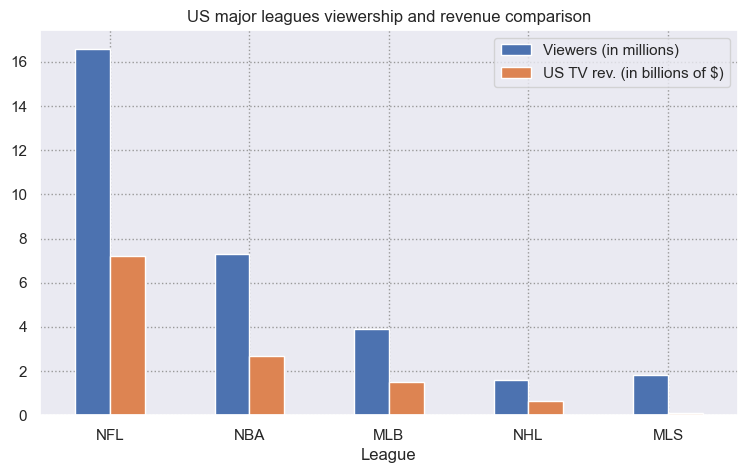

In [11]:
major_league_comparison.plot(
    x="League",
    y=["Viewers (in millions)", "US TV rev. (in billions of $)"],
    kind="bar",
    rot=0,
    title="US major leagues viewership and revenue comparison",
)

# Display a legend for the chart
plt.legend()

# Save the chart to a file with a resolution of 300 dpi
plt.savefig("imgs/major_league_viewership_comparison.png", dpi=300)

### GENERATE VISUALIZATION OF EVOLUTION OF NBA VIDEOS

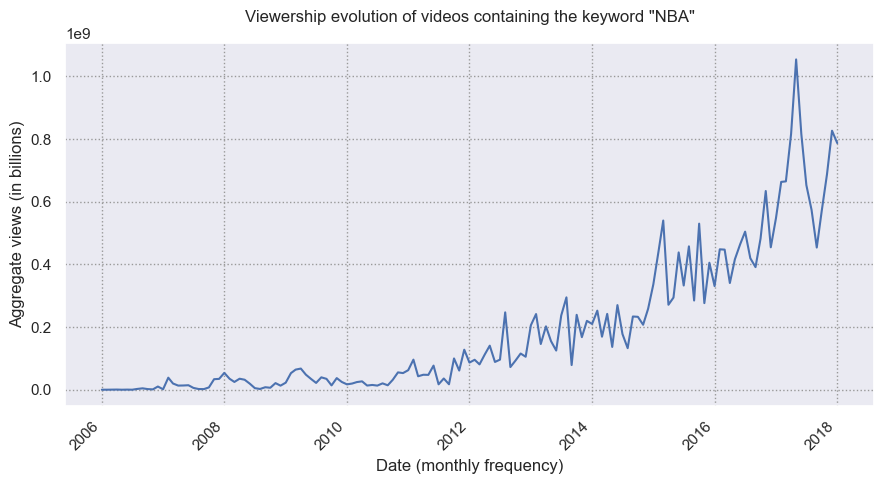

In [12]:
df = nba_basketball_views_per_year_df.copy()

# Set 'year_month' column as index, sort by index in ascending order, and reset index
df.sort_index(inplace=True, ascending=True)
df.reset_index(inplace=True)

# Plot 'total_nba_views' against 'year_month' for rows with 'year_month' <= '2018-01-01'
df[df.year_month <= "2018-01-01"].plot(x="year_month", y="total_nba_views", legend=None)

# Customize plot
plt.xticks(rotation=45)
plt.xlabel("Date (monthly frequency)")
plt.ylabel("Aggregate views (in billions)")
plt.title('Viewership evolution of videos containing the keyword "NBA"', pad=15)
plt.tight_layout()

# Save plot as image file
plt.savefig("imgs/viewership_evolution_nba.jpeg", dpi=400)

## BIG MARKET VS SMALL MARKET TEAMS

### DATA VISUALISATION FOR THE MARKET SIZE COMPARISON

In [13]:
def to_real_market_size(elem):
    if "M" in elem:
        return float(elem[:-1])
    if "K" in elem:
        return float(elem[:-1]) / 1000
    else:
        return np.nan

# Read the csv file into a pandas DataFrame
market_size_df = pd.read_csv("./data/market_sizes.csv")
market_size_df["TV MARKET SIZE"] = market_size_df["TV MARKET SIZE"].apply(to_real_market_size)
market_size_df["METRO POPULATION"] = market_size_df["METRO POPULATION"].apply(lambda x: x / (10**6))
market_size_df["MARKET TYPE"] = market_size_df["TV MARKET SIZE"].apply(lambda x: "BIG MARKET" if x > 2 else "SMALL MARKET" if x < 1.5 else "MEDIUM MARKET")
market_size_df.head()

,TEAM,TV MARKET SIZE,METRO POPULATION,MARKET TYPE
0,Knicks / Nets,7.453,19.216182,BIG MARKET
1,Lakers / Clippers,5.735,13.214799,BIG MARKET
2,Bulls,3.472,9.458539,BIG MARKET
3,76ers,2.997,6.102434,BIG MARKET
4,Mavericks,2.963,7.573136,BIG MARKET


In [14]:
# Set figure size and create subplot
fig = px.scatter(
    market_size_df,
    x="TV MARKET SIZE",
    y="METRO POPULATION",
    custom_data=["TEAM"],
    color="MARKET TYPE",
    size=market_size_df["METRO POPULATION"],
    log_x=True,
    log_y=False,
    width=1000,
    height=700,
)

# Add vertical lines
fig.add_shape(type="line", x0=2, x1=2, y0=0, y1=1, name="1.5M", yref="paper", line=dict(color="red", width=2))
fig.add_shape(type="line", x0=1.5, x1=1.5, y0=0, y1=1, yref="paper", line=dict(color="red", width=2))


# Add title and axis labels
fig.update_layout(
    xaxis_title="TV Market Size (in millions)",
    xaxis_title_font=dict(size=14),
    yaxis_title="Metro Population (in millions)",
    yaxis_title_font=dict(size=14),
)

# Add hover labels for team names
fig.update_traces(hovertemplate="<b>%{customdata[0]}</b>")
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
    )
)
fig.update_layout(yaxis_range=[0, 15])
fig.update_layout(xaxis_range=[0, 0.8])


# fig.update_layout(hovermode='x unified')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=0.8))
fig.show()

fig.write_html("data/team_market_size_comparison.html")

py.plot(fig, filename="market_size_comparison", auto_open=False)

'https://plotly.com/~abiola_adeye/1/'

### STUDY OF THE DISTRIBUTION OF VIDEOS VIEWS

In [15]:
# Eliminate limit years to avoid undiserable results when computing seasons
df = all_team_results.copy()
df = df[df.year_month.dt.year != 2006]
df = df[df.season != '2019-2020']

In [16]:
small_vs_big = df.groupby(["season", "market_size"]).sum().drop(["total_nba_views", "view_count"], axis=1)
small_vs_big.reset_index(inplace=True)
display(small_vs_big)

big_market_percentage_df = small_vs_big[small_vs_big["market_size"] == "big"]
small_market_percentage_df = small_vs_big[small_vs_big["market_size"] == "small"]

,season,market_size,total_nba_view_percentage
0,2006-2007,big,0.517546
1,2006-2007,small,0.647274
2,2007-2008,big,1.526961
3,2007-2008,small,0.207399
4,2008-2009,big,2.074213
5,2008-2009,small,0.223640
6,2009-2010,big,2.646010
7,2009-2010,small,0.559835
8,2010-2011,big,3.990077
9,2010-2011,small,0.560517


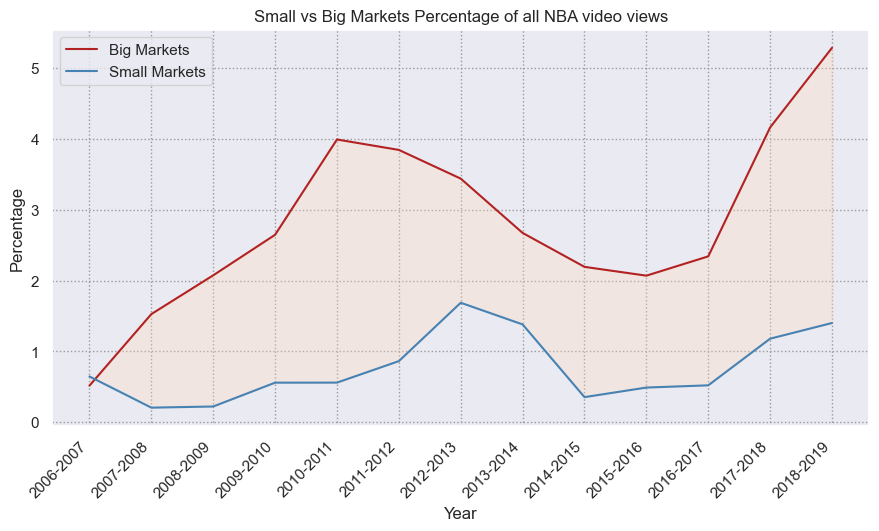

In [17]:
plt.fill_between(
    big_market_percentage_df["season"],
    big_market_percentage_df["total_nba_view_percentage"],
    small_market_percentage_df["total_nba_view_percentage"],
    color="peachpuff",
    alpha=0.3,
)
plt.plot(big_market_percentage_df["season"], big_market_percentage_df["total_nba_view_percentage"], color="firebrick", label="Big Markets")
plt.plot(small_market_percentage_df["season"], small_market_percentage_df["total_nba_view_percentage"], color="steelblue", label="Small Markets")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.title("Small vs Big Markets Percentage of all NBA video views")
plt.legend()
plt.tight_layout()

# Rotate and align the tick labels so they look better
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment="right")

# Save the chart to a file with a resolution of 300 dpi
plt.savefig("imgs/small_vs_big_market_percentge_comparison.png", dpi=300, bbox_inches='tight')

plt.show()

In [21]:
percentage_per_season = df.groupby("season").sum().drop(["total_nba_views"], axis=1)

views_per_team = df.groupby(["season", "team"]).agg({"total_nba_view_percentage": "sum", "market_size": "first", "view_count": "sum"})

# Divide each team's views by the total views for that season
views_per_team["subset_percentage"] = views_per_team["total_nba_view_percentage"].div(
    percentage_per_season["total_nba_view_percentage"], axis=0, level="season"
)
views_per_team.rename(columns={"view_count": "Views"}, inplace=True)
views_per_team.reset_index(inplace=True)
views_per_team

# Create a plotly pie chart, where the season is an additional dimension
fig = px.pie(
    views_per_team,
    values="subset_percentage",
    names="team",
    color="team",
    title="Percentage of all NBA video views by team",
    color_discrete_map={"big": "firebrick", "small": "steelblue"},
    labels={"subset_percentage": "Percentage of all NBA video views by team"},
    hover_data=["market_size"],
    width=800,
    height=800,
)
# center the title
fig.update_layout(title_x=0.5)
fig

In [19]:
# Create a bar plot displaying the percentage of views for each team as a fraction of the total views for that season
# and color the bars by market size
fig = px.bar(
    views_per_team,
    x="team",
    y=views_per_team.subset_percentage * 100,
    color="market_size",
    barmode="stack",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    animation_frame="season",
    animation_group="team",
    custom_data=["Views"],
)

fig.update_layout(
    #title="Distribution of views inside our subset by team",
    xaxis_title="Team",
    yaxis_title="Percentage",
    legend_title="Market Size",
    title_x=0.5,
    yaxis_range=[0, 55],
)

# Add hover labels for team names
fig.update_traces(
    hovertemplate="<b>Number of views: %{customdata[0]}</b>")
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Ubuntu",
    )
)

py.plot(fig, filename="distribution_of_views_animation", auto_open=False)
fig


### DIRECTION OF FREE AGENT MOVES IN THE NBA BETWEEN 2020 and 2021

In [22]:
# Read csv files for the free agent moves for the 2021 and 2022 seasons
free_agent_moves_2021 = pd.read_csv("./data/free_agent_moves/2021_free_agent_moves.csv")
free_agent_moves_2022 = pd.read_csv("./data/free_agent_moves/2022_free_agent_moves.csv")

# Concatenate the two dataframes
free_agent_moves = pd.concat([free_agent_moves_2021, free_agent_moves_2022])

# Keep only the rows where the NEWS column starts with "Signs with"
free_agent_moves = free_agent_moves[free_agent_moves["NEWS"].str.startswith("Signs with") | False]

# Add from and to columns to see direction of trade
free_agent_moves['TO'] = free_agent_moves['NEWS'].str.split(' ').str[2]
free_agent_moves['FROM'] = ""

# Save the concatenate dataframe to a csv file
# free_agent_moves.to_csv("./data/free_agent_moves/free_agent_moves.csv", index=False)

In [23]:
# Reload file after manually completing "TO" column
free_agent_moves = pd.read_csv("./data/free_agent_moves/free_agent_moves.csv")
free_agent_moves.drop(['EXP', 'NEWS', 'TYPE','POS'], axis=1, inplace=True)

In [25]:
def map_market_size(team):
    if team in BigMarkets:
        return 2
    elif team in MediumMarkets:
        return 1
    else:
        return 0

free_agent_moves['TO_MARKET'] = free_agent_moves['TO'].map(map_market_size)
free_agent_moves['FROM_MARKET'] = free_agent_moves['FROM'].map(map_market_size)
free_agent_moves

,NAME,AGE,PPG,RPG,APG,TO,FROM,TO_MARKET,FROM_MARKET
0,DeMar DeRozan,33,25.9,5.0,4.7,CHI,SAS,2,0
1,Carmelo Anthony,38,22.5,6.2,2.7,LAL,POR,2,0
2,Kelly Oubre Jr.,27,20.8,5.3,1.3,CHA,GSW,0,2
3,Dwight Howard,37,15.7,11.8,1.3,LAL,PHI,2,2
4,Malik Monk,24,14.2,2.2,4.0,LAL,CHA,2,0
5,Paul Millsap,37,13.4,7.1,2.2,BKN,DEN,0,1
6,Kemba Walker,32,12.8,3.2,3.4,NY,OKC,2,0
7,Enes Freedom,30,11.2,7.8,0.9,BOS,POR,2,0
8,Trevor Ariza,37,10.4,4.8,2.1,LAL,MIA,2,1
9,Elfrid Payton,28,10.1,4.0,5.7,PHX,NY,2,2


In [30]:
df_from_large_to_small = free_agent_moves[(free_agent_moves['PPG'] > 0) & (free_agent_moves['TO_MARKET'] < free_agent_moves['FROM_MARKET'])]
display(df_from_large_to_small)

df_from_small_to_large = free_agent_moves[(free_agent_moves['PPG'] > 0) & (free_agent_moves['TO_MARKET'] > free_agent_moves['FROM_MARKET'])]
display(df_from_small_to_large)

df_eq_moves = free_agent_moves[(free_agent_moves['PPG'] > 0) & (free_agent_moves['TO_MARKET'] == free_agent_moves['FROM_MARKET'])]
display(df_eq_moves)

,NAME,AGE,PPG,RPG,APG,TO,FROM,TO_MARKET,FROM_MARKET
2,Kelly Oubre Jr.,27,20.8,5.3,1.3,CHA,GSW,0,2
5,Paul Millsap,37,13.4,7.1,2.2,BKN,DEN,0,1
13,Malik Monk,24,14.2,2.2,4.0,SAC,LAL,0,2


,NAME,AGE,PPG,RPG,APG,TO,FROM,TO_MARKET,FROM_MARKET
0,DeMar DeRozan,33,25.9,5.0,4.7,CHI,SAS,2,0
1,Carmelo Anthony,38,22.5,6.2,2.7,LAL,POR,2,0
4,Malik Monk,24,14.2,2.2,4.0,LAL,CHA,2,0
6,Kemba Walker,32,12.8,3.2,3.4,NY,OKC,2,0
7,Enes Freedom,30,11.2,7.8,0.9,BOS,POR,2,0
8,Trevor Ariza,37,10.4,4.8,2.1,LAL,MIA,2,1
12,Lonnie Walker IV,24,15.5,2.5,1.5,LAL,SAS,2,0
14,Bruce Brown,26,11.3,4.4,4.3,DEN,BKN,1,0


,NAME,AGE,PPG,RPG,APG,TO,FROM,TO_MARKET,FROM_MARKET
3,Dwight Howard,37,15.7,11.8,1.3,LAL,PHI,2,2
9,Elfrid Payton,28,10.1,4.0,5.7,PHX,NY,2,2
10,Zach Collins,25,8.9,5.8,2.9,SAS,POR,0,0
11,Jalen Brunson,26,20.4,3.2,6.3,NY,DAL,2,2
15,Thomas Bryant,25,10.6,4.9,0.9,LAL,WSH,2,2


### STUDY ON THE CORRELATION BETWEEN VIEWS AND WINNING PERCENTAGE

In [33]:
all_team_results = pd.read_csv("./data/all_team_results.csv" , parse_dates=['year_month'])
all_team_results.head()

,year_month,view_count,team,market_size,total_nba_views,total_nba_view_percentage,season
0,2016-04-01,43943996.0,LAL,big,340539239.0,0.129042,2015-2016
1,2016-04-01,114950.0,NY,big,340539239.0,0.000338,2015-2016
2,2016-04-01,3870363.0,CHI,big,340539239.0,0.011365,2015-2016
3,2016-04-01,743567.0,PHI,big,340539239.0,0.002183,2015-2016
4,2016-04-01,925314.0,DAL,big,340539239.0,0.002717,2015-2016


<div class="alert alert-block alert-info">
To compare our view ratio with the teams' results, we import from our database the monthly occupancy rate of the stadium of each team and the winning rate on the matches since the beginning of each season.

In [36]:
# Connect to the database
con = sqlite3.connect("data/nba_api.sqlite")

# Read the data from the database
occupancy_rate_df = pd.read_sql_query(
    """
    select   home,
                avg(attendance) as avg_attendace,
                round(avg(attendance/season_high_attendance*100),2) as avg_occupancy_rate,
                strftime('%Y-%m',time) as year_month
    from game_data
    group by home, year_month
    """,
    con,
)
occupancy_rate_df = occupancy_rate_df.reset_index()
display(occupancy_rate_df.home.unique()) # Display query results

# Filter out teams that are not in the correspondence dictionary
occupancy_rate_df = occupancy_rate_df[occupancy_rate_df["home"].isin(Correspondence.keys())]

winning_rate_df = pd.read_sql_query(
    """
    select  home as team,
            strftime('%Y-%m', time) as year_month,
            last_value(curr_season_win_pct) over (partition by home, strftime('%Y-%m', time) order by time) as win_percentage
            from game_data
            group by home, year_month;
""",
    con,
)
winning_rate_df = winning_rate_df.reset_index()

# Filter out teams that are not in the correspondence dictionary
winning_rate_df = winning_rate_df[winning_rate_df["team"].isin(Correspondence.keys())]

winning_rate_df["year_month"] = pd.to_datetime(winning_rate_df["year_month"])
occupancy_rate_df["year_month"] = pd.to_datetime(occupancy_rate_df["year_month"])

winning_rate_df["team"] = winning_rate_df["team"].apply(lambda x: Correspondence[x])
occupancy_rate_df["team"] = occupancy_rate_df["home"].apply(lambda x: Correspondence[x])

winning_rate_df.head(10)

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Bobcats', 'Charlotte Hornets', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets',
       'Detroit Pistons', 'Golden State Warriors', 'Houston Rockets',
       'Indiana Pacers', 'Los Angeles Clippers', 'Los Angeles Lakers',
       'Memphis Grizzlies', 'Miami Heat', 'Milwaukee Bucks',
       'Minnesota Timberwolves', 'New Jersey Nets', 'New Orleans Hornets',
       'New Orleans Pelicans', 'New Orleans/Oklahoma City Hornets',
       'New York Knicks', 'Oklahoma City Thunder', 'Orlando Magic',
       'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers',
       'Sacramento Kings', 'San Antonio Spurs', 'Seattle SuperSonics',
       'Toronto Raptors', 'Utah Jazz', 'Washington Wizards'], dtype=object)

,index,team,year_month,win_percentage
0,0,ATL,2004-11-01,0.000000
1,1,ATL,2004-12-01,0.133333
2,2,ATL,2005-01-01,0.161290
3,3,ATL,2005-02-01,0.195652
4,4,ATL,2005-03-01,0.172414
5,5,ATL,2005-04-01,0.152778
6,6,ATL,2005-11-01,0.000000
7,7,ATL,2005-12-01,0.133333
8,8,ATL,2006-01-01,0.241379
9,9,ATL,2006-02-01,0.311111


In [37]:
# Add winning percentages and occupancy percentages for every team to all team results df
all_team_results = all_team_results.merge(winning_rate_df.drop(
    ["index"], axis=1), on=["team", "year_month"], how="inner")
all_team_results = all_team_results.merge(occupancy_rate_df.drop(
    ["index", "home"], axis=1), on=["team", "year_month"], how="inner")

# Save to csv since computation is expensive
all_team_results.to_csv("data/all_team_results_with_winning_percentages.csv")

all_team_results.head()

,year_month,view_count,team,market_size,total_nba_views,total_nba_view_percentage,season,win_percentage,avg_attendace,avg_occupancy_rate
0,2016-04-01,43943996.0,LAL,big,340539239.0,0.129042,2015-2016,0.210526,18997.000000,100.00
1,2016-04-01,114950.0,NY,big,340539239.0,0.000338,2015-2016,0.402597,19812.000000,100.00
2,2016-04-01,3870363.0,CHI,big,340539239.0,0.011365,2015-2016,0.500000,22053.333333,95.25
3,2016-04-01,743567.0,PHI,big,340539239.0,0.002183,2015-2016,0.116883,15633.500000,75.17
4,2016-04-01,925314.0,DAL,big,340539239.0,0.002717,2015-2016,0.512821,20266.200000,98.78


In [38]:
# Add a new column that is the mean of view_counts per year_month
all_team_results["mean_view_count"] = all_team_results.groupby("year_month")["view_count"].transform("mean")
all_team_results["std_view_count"] = all_team_results.groupby("year_month")["view_count"].transform("std").fillna(1)

all_team_results['view_count_normalized'] = (all_team_results['view_count'] - all_team_results['mean_view_count']) / all_team_results['std_view_count']
all_team_results['year'] = all_team_results['year_month'].dt.year

In [39]:
#compute correlation between view_count and win_percentage for both big and small market teams
grouped_views_and_wins_df = all_team_results.groupby('market_size').agg({
    "view_count_normalized": lambda x: list(x),
    "win_percentage": lambda x: list(x),
})

correlations = {}
for market_size in ['small', 'big']:
    df = grouped_views_and_wins_df[grouped_views_and_wins_df.index == market_size]

    correlations[market_size] = pearsonr(
        df["view_count_normalized"].iloc[0], df["win_percentage"].iloc[0])
correlations

{'small': PearsonRResult(statistic=0.1251338345520804, pvalue=0.003809288604368298),
 'big': PearsonRResult(statistic=0.04482248488525619, pvalue=0.3385153512321321)}